In [58]:
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
import tensorboardX
from tqdm import tqdm_notebook

In [2]:
import sys
sys.path.append('./tensorboard')
from mnist import Net

In [3]:
model = Net()
model.load_state_dict(torch.load('tensorboard/mnist.pht'))

In [4]:
model

Net(
  (features): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [20]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=128, shuffle=True)

In [21]:
X, y = iter(train_loader).next()

In [22]:
X.size(), y.size()

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

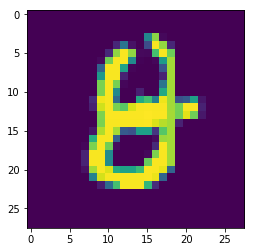

In [49]:
img = X[0][0]
import matplotlib.pyplot as plt
plt.imshow(img)

In [8]:
model

Net(
  (features): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
  (fc): Sequential(
    (0): Linear(in_features=320, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
)

In [17]:
class MNIST_Feature(nn.Module):
    def __init__(self):
        super(MNIST_Feature, self).__init__()
        self.features = nn.Sequential(
            *list(model.features.children())
        )
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(-1, 320)
        return x

In [32]:
extract_feature = MNIST_Feature()
extract_feature

MNIST_Feature(
  (features): Sequential(
    (0): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): ReLU()
  )
)

In [33]:
extract_feature(X).size()

torch.Size([128, 320])

In [63]:
features = torch.zeros(0)
labels = torch.zeros(0).long()
label_imgs = torch.zeros(0)

for batch_idx, (img, target) in enumerate(train_loader):
    feature = extract_feature(img)
    features = torch.cat((features, feature))
    labels = torch.cat((labels, target))
    label_imgs = torch.cat((label_imgs, img))

In [65]:
features.size()

torch.Size([60000, 320])

In [66]:
labels.size()

torch.Size([60000])

In [67]:
label_imgs.size()

torch.Size([60000, 1, 28, 28])

In [70]:
# TensorboardにEmbeddingを描画
import tensorboardX
writer = tensorboardX.SummaryWriter()
writer.add_embedding(features[:1000], metadata=labels[:1000], label_img=label_imgs[:1000])
writer.close()

In [108]:
import torch
import torch.nn as nn
from torchvision import models

model = models.alexnet(pretrained=True)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /Users/koichiro.mori/.torch/models/alexnet-owt-4df8aa71.pth
100%|██████████| 244418560/244418560 [00:35<00:00, 6854938.63it/s] 


In [111]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [120]:
list(model.classifier.children())[:-1]

[Dropout(p=0.5),
 Linear(in_features=9216, out_features=4096, bias=True),
 ReLU(inplace),
 Dropout(p=0.5),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace)]

In [121]:
new_classifier = nn.Sequential(*list(model.classifier.children())[:-1])

In [122]:
new_classifier

Sequential(
  (0): Dropout(p=0.5)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace)
  (3): Dropout(p=0.5)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace)
)

In [124]:
model.classifier = new_classifier

In [125]:
model

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Dropout(p=0.5)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
    (2): ReLU(inplace)
    (3): Dropout(p=0.5)
    (4): Linear(in_features=4096, out_feature

In [128]:
import torch
import torch.nn as nn
from torchvision import models

original_model = models.alexnet(pretrained=True)

In [134]:
list(original_model.features.children())[:-3]

[Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace)]

In [135]:
class AlexNetConv4(nn.Module):
    def __init__(self):
        super(AlexNetConv4, self).__init__()
        self.features = nn.Sequential(
            *list(original_model.features.children())[:-3]
        )
    
    def forward(self, x):
        x = self.features(x)
        return x

In [137]:
model = AlexNetConv4()
model

AlexNetConv4(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace)
  )
)